# NEU Surface Defect Dataset

### Dataset Details
The original dataset contains 1800 images of 6 types of surface defects in hot-rolled steel strip. The images we will be working with are RGB bitmap images with the class of the defect noted as a two-character code in the filename. The codes and defect types are noted below:
- Cr: Crazing
- In: Inclusion
- Pa: Patches
- PS: Pitted Surface
- RS: Rolled-in Scale
- Sc: Scratch

The details about how to prepare data can be check via Andrew's tutorial [here](https://github.com/holmgroup/NextGen2020/blob/master/notebooks/0.0_Loading_NEU_Data.ipynb).

# CNN Image Representation

### Convolutional Neural Network Recap

There are four main operations/layers in a CNN:
1. Convolution: The primary purpose of Convolution is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data. Convolution layer use filter matrix to detect features.

<center><img src="https://ujwlkarn.files.wordpress.com/2016/08/giphy.gif?w=480&zoom=2" style="zoom:80%"/></center>

2. Non-Linearity(RELU): Introduce non-linearity in CNN to learn complex mapping from image to representations. RELU is mostly used because it is simple, easy to compute and can overcome problems of gradient in training process.

3. Max Pooling: Reduce the spatial dimension of each feature map but retains the most important information. Reduce the number of parameters and computations. Make the network invariant to small transformations, distortions and translations. It is crucial in extracting useful features at different scales.

4. Fully Connected Layer: A traditional Multi Layer Perceptron neural network to make prediction. The feature vector in fully connected layer can be used as a high-level representation of the image (our CNN representation).

A great online visualization of CNN for handwritten digits recognition (https://www.cs.ryerson.ca/~aharley/vis/conv/)
### Exercise Goals
1. Get started with PyTorch
2. Extract fc1 feature vector from pretrained VGG16
3. Visualize the CNN feature vector
4. Extract and visualize intermediate feature maps (optional)
___

### Install Packages
`pip install -r requirements.txt`
or `pip install torch torchvision tqdm`

In [1]:
import numpy as np, os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm # a tool to visualize for loop process

import PIL
import torch
import torch.nn as nn
from torchvision.models import vgg16
import torchvision.transforms as transforms
from torch.autograd import Variable

%matplotlib inline

## 1. Get started with PyTorch

PyTorch is a deep learning research platform. The other popular options are TensorFlow and Keras.

Data in PyTorch is in the form of Tensors. Tensors are similar to NumPy’s ndarrays, with the addition being that Tensors can also be used on a GPU to accelerate computing. For modern deep neural networks, GPUs often provide speedups of 50x or greater.

Examples:

In [2]:
x = torch.rand(10,10)
print(type(x))
print(x.shape)
print(x.unsqueeze(0).shape) # add extra dimension at first dimension

<class 'torch.Tensor'>
torch.Size([10, 10])
torch.Size([1, 10, 10])


### `torch.nn`: define neural network layers and model

In [3]:
# suppose we have a 2 images batch with 10x10 widthxheight
x = torch.rand(2, 3, 10, 10) 
# convolution layer take input [N, C, W, H]
conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
x = conv(x)
print(x.shape)

torch.Size([2, 16, 10, 10])


In [4]:
# ReLU activation
relu = nn.ReLU()
x = relu(x)
# Max Pooling
maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
x = maxpool(x)
print(x.shape)

torch.Size([2, 16, 5, 5])


In [5]:
# flatten the feature map into a long vector
x = torch.flatten(x, 1)
print(x.shape)

torch.Size([2, 400])


In [6]:
# fully connected layer
fc = nn.Linear(in_features=400, out_features=100)
x = fc(x)
print(x.shape)

torch.Size([2, 100])


In [7]:
# create a model to put these all together
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc = nn.Linear(in_features=400, out_features=100)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

net = Net()
x = torch.rand(2, 3, 10, 10) 
x = net(x) # forward is called
print(x.shape)

torch.Size([2, 100])


## 2. Get feature vectors from pretrained VGG16
In this section, we will work on extracting CNN representation from pretrained VGG16 deep convolutional neural network.

<img src="https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png" style="zoom:80%" />
<img src="https://qph.fs.quoracdn.net/main-qimg-83c7dee9e8b039c3ca27c8dd91cacbb4" style="zoom:100%" />

In [8]:
vgg16() # see the architecture

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# define our model
class VGG_fc1(nn.Module):
    def __init__(self):
        super(VGG_fc1, self).__init__()
        self.features = vgg16(pretrained=True).features # convolutional layers
        self.avgpool = vgg16(pretrained=True).avgpool
        self.fc1 = vgg16(pretrained=True).classifier[0] # first layer of classifier
        
    def forward(self, x):
        """Extract first fully connected feature vector"""
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
model = VGG_fc1().eval() # turn model into evaluation mode

In [10]:
# load pre-stored data
DF_PATH = os.path.join('..', 'data', 'NEU_dataframe.pkl')
df = pd.read_pickle(DF_PATH)

# visualize dataframe
df.head()

,image_path,label
0,../data/NEU-CLS/Sc_1.bmp,Sc
1,../data/NEU-CLS/Sc_215.bmp,Sc
2,../data/NEU-CLS/Sc_201.bmp,Sc
3,../data/NEU-CLS/Pa_169.bmp,Pa
4,../data/NEU-CLS/Pa_141.bmp,Pa


In [11]:
image_paths = df['image_path']

# image_paths is an python iterable
image_paths[0:5]

0      ../data/NEU-CLS/Sc_1.bmp
1    ../data/NEU-CLS/Sc_215.bmp
2    ../data/NEU-CLS/Sc_201.bmp
3    ../data/NEU-CLS/Pa_169.bmp
4    ../data/NEU-CLS/Pa_141.bmp
Name: image_path, dtype: object

In [12]:
# transform from image to the input of CNN, follow the same procedure as ImageNet
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize the image to 224x224
    transforms.ToTensor(), # convert pixel values to the range of [0,1]
    # normalize the pixel values according to the mean and std of ImageNet
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))]) 

In [13]:
def load_image(path):
    '''Load a image and convert it to a pytorch Tensor as input to CNN'''
    img = PIL.Image.open(path) # Load the image with Pillow library
    img = img.convert('RGB') # Convert the image into RGB mode
    img = transform(img) # Transform the image
    return img

def get_feature(path):
    '''Run a pytorch Tensor through VGG16 and get feature vector '''
    img = load_image(path)
    img = img.unsqueeze(0) # make the tensor into single batch tensor with shape [1, 3, 224, 224]
    feature = model(img) # get feature
    feature = feature.detach().numpy() # detach the gradient, convert to numpy array
    return feature.flatten()

In [14]:
# test the procedure for a single image
feature = get_feature(image_paths[0])
print("shape of feature:", feature.shape)

shape of feature: (4096,)


In [15]:
features = [] # create a list to store all the features
for image_path in tqdm(image_paths):
    feature = get_feature(image_path)
    features.append(feature)

print(np.array(features).shape)

100%|██████████| 1800/1800 [15:51<00:00,  1.89it/s]

(1800, 4096)


In [16]:
# store the features for future use
df['vgg16_fc1_feature'] = features
df.to_pickle('../data/NEU_dataframe_CNN.pkl')
df.head()

,image_path,label,vgg16_fc1_feature
0,../data/NEU-CLS/Sc_1.bmp,Sc,"[1.147158, 0.6401806, 1.2257015, -2.1971653, 0..."
1,../data/NEU-CLS/Sc_215.bmp,Sc,"[0.5869419, 0.6092262, 0.85538065, -2.8170152,..."
2,../data/NEU-CLS/Sc_201.bmp,Sc,"[0.71291727, -0.62916744, 1.4726174, -3.480781..."
3,../data/NEU-CLS/Pa_169.bmp,Pa,"[0.49886426, 0.01762607, 0.11037265, -3.781802..."
4,../data/NEU-CLS/Pa_141.bmp,Pa,"[1.5004536, -0.09696133, 0.376126, -3.0572588,..."


## 3. Visualize the feature vector

In [17]:
# obtain features from stored dataframe
df = pd.read_pickle('../data/NEU_dataframe_CNN.pkl')
features = df['vgg16_fc1_feature']
features = np.array(list(features)) # convert all stored features to a (1800, 4096) numpy array
features.shape

(1800, 4096)

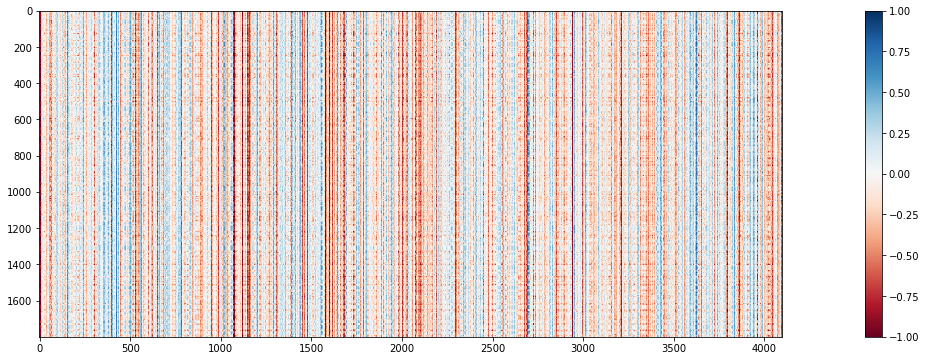

In [18]:
plt.figure(figsize=(30,6))
# visualize the features as image, clip the values less than -1 and more than 1 for better visualization
plt.imshow(features, cmap='RdBu', vmin=-1, vmax=1) 
plt.colorbar()

This is a visualization of randomly ordered image features. We want to visualize the CNN representation for each class. One way to do this is sort the dataframe by the label

In [19]:
df_sort =  df.sort_values('label') # sort the dataframe by the label
df_sort

,image_path,label,vgg16_fc1_feature
1016,../data/NEU-CLS/Cr_290.bmp,Cr,"[0.4671379, -0.96027267, -0.053909786, -2.2900..."
680,../data/NEU-CLS/Cr_271.bmp,Cr,"[0.58636534, -0.39396453, -0.44101214, -2.2798..."
1281,../data/NEU-CLS/Cr_243.bmp,Cr,"[1.0543275, -0.15110908, -0.1214737, -2.284181..."
683,../data/NEU-CLS/Cr_31.bmp,Cr,"[0.49397248, -0.93722653, -0.4639089, -2.41064..."
1600,../data/NEU-CLS/Cr_88.bmp,Cr,"[0.69228613, -0.4607449, -0.30382752, -2.28455..."
...,...,...,...
1221,../data/NEU-CLS/Sc_132.bmp,Sc,"[0.34698617, 0.36746746, 0.24099708, -4.311982..."
379,../data/NEU-CLS/Sc_69.bmp,Sc,"[1.0027242, 0.16411895, 1.1416802, -3.2639399,..."
382,../data/NEU-CLS/Sc_41.bmp,Sc,"[1.0085729, 0.5062659, 1.4809661, -3.4798248, ..."
715,../data/NEU-CLS/Sc_270.bmp,Sc,"[0.40473232, -1.0820489, 0.2985593, -4.608058,..."


In [20]:
df_sort['label'].unique()

array(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'], dtype=object)

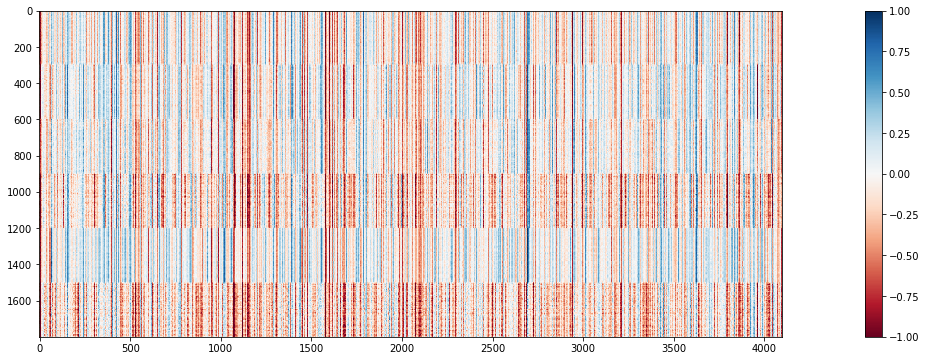

In [21]:
# visualize sorted features
features_sort = df_sort['vgg16_fc1_feature']
features_sort = np.array(list(features_sort))
plt.figure(figsize=(30,6))
plt.imshow(features_sort, cmap='RdBu', vmin=-1, vmax=1)
plt.colorbar()

What we can get from the visualization:
1. CNN representations of the images in the same class have similar pattern
2. CNN representations of the images in the different class have different pattern

Therefore, we are condifident that the CNN representations would be good for the purpose of classification.

## 4. Visualize intermediate feature maps (optional)

In [22]:
# define another model to for extracting feature maps
class VGG_fmap(nn.Module):
    def __init__(self):
        """Select activation maps."""
        super(VGG_fmap, self).__init__()
        self.select = ['3', '8', '15', '22', '29']
        self.features = vgg16(pretrained=True).features
        self.avgpool = vgg16(pretrained=True).avgpool
        self.linear = vgg16(pretrained=True).classifier[0]
        
    def forward(self, x):
        """Extract multiple convolutional feature maps."""
        fmaps = []
        for name, layer in self.features._modules.items():
            x = layer(x)
            if name in self.select:
                fmaps.append(x.detach().numpy()) # detach the gradient, convert to numpy array
        return fmaps
    
model_fmap = VGG_fmap().eval()

In [23]:
def get_feature_maps(path):
    '''Run a pytorch Tensor through VGG16 and get feature vector '''
    img = load_image(path)
    img = img.unsqueeze(0) # make the tensor into single batch tensor with shape [1, 3, 224, 224]
    fmaps = model_fmap(img) # get feature maps
    fmaps = [fmap.squeeze() for fmap in fmaps]
    return fmaps

In [24]:
path = image_paths[np.random.choice(1800)] # get a random image
fmaps = get_feature_maps(path)
for fmap in fmaps:
    print(fmap.shape)

(64, 224, 224)
(128, 112, 112)
(256, 56, 56)
(512, 28, 28)
(512, 14, 14)


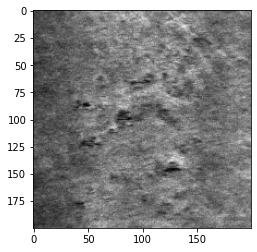

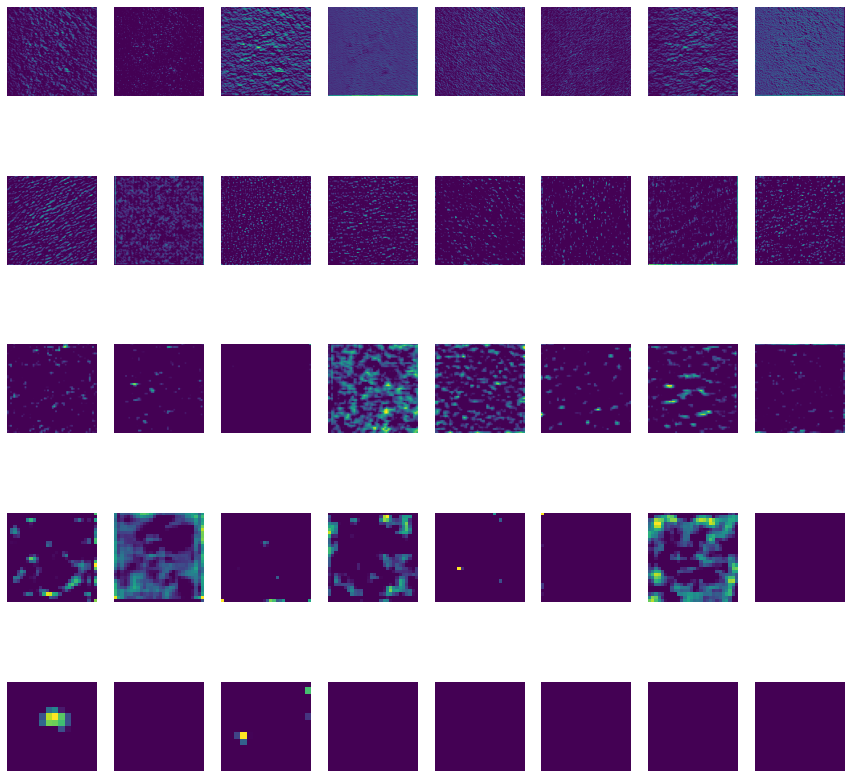

In [25]:
image = PIL.Image.open(path)
plt.imshow(image, cmap='gray')
plt.show()
# visualization of feature maps
n_channels = 8
fig, axes = plt.subplots(ncols=n_channels, nrows=5, figsize=(15,15))
# for every feature map block, show the first n_channels of the feature map
for i in range(5):
    for j in range(n_channels):
        axes[i][j].imshow(fmaps[i][j])
        axes[i][j].axis('off')

The intermediate feature maps can also be used as feature representations. It would be a very interesting study to compare the feature map representations at different level and the fully connected feature vectors.

## Summary

In this tutorial, we learn how to extract CNN representations from pretrained VGG16 in PyTorch framework. The procedure in this notebook is only one way to achieve this goal. Feel free to try other deep learning frameworks and pipelines. As we can see, CNN representation is a very powerful way to describe a image. It incorporate rich feature information at different scale. Now with the powerful CNN representations, we can use unsupervised and supervised machine learning methods to perform further analysis and make predictions.